In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


# Import simulation parameters from web exported JSON file

In [2]:
import os
import json
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.datatypes import noise_framework
from tvb.datatypes.equations import HRFKernelEquation
from tvb.basic.traits.parameters_factory import *

available_models = get_traited_subclasses(models.Model)
available_monitors = get_traited_subclasses(monitors.Monitor)
available_integrators = get_traited_subclasses(integrators.Integrator)
available_couplings = get_traited_subclasses(coupling.Coupling)

   INFO  log level set to INFO


Having a path towards the exported JSON, we will: 
- read the simulation parameters as strings, 
- transform them into objects, 
- run the simulation, and 
- plot some timeseries results at the end.

Let us start by reading the JSON from a file path.

In [14]:
with open('tvb_simulation_3.json', 'r') as fdr:
    with open('tvbsim.json', 'w') as fdw:
        json.dump(json.loads(json.load(fdr)['_simulator_configuration']), fdw, indent=1)


In [27]:
json_path = "tvb_simulation_3.json"

def ignore_key(key): # v1.4 -> 1.5 compat
    keys = ['_noise', 'pre_expr', 'post_expr']
    return any(k in key for k in keys)

with open(json_path, 'rb') as input_file:
    simulation_json = input_file.read()
    simulation_json = json.loads(simulation_json)
    simulation_config = {}
    for key, val in json.loads(simulation_json["_simulator_configuration"]):
        nonempty_key = len(key) > 1
        no_noise_v14 = '_noise' not in key
        no_pre_expr_v141 = key.startswith('monitors') and not key.endswith('pre_expr')
        no_post_expr_v141 = key.startswith('monitors') and not key.endswith('post_expr')
        if nonempty_key and no_pre_expr_v141 and no_post_expr_v141:
            simulation_config[key, valu]

Next, we will transform the JSON into simulator params.

We do that by first grouping parameters over configuration class (model, integrator, coupling, etc.)

In [28]:
model_key = 'model'
model_name = simulation_config[model_key]
#noise_key = '%s%s%s%s_noise' % (model_key, KEYWORD_PARAMS, KEYWORD_OPTION, model_name)
#noise_name = simulation_config[noise_key]
#random_stream_key = '%s%s%s%s_random_stream' % (noise_key, KEYWORD_PARAMS, KEYWORD_OPTION, noise_name)

selectors = ['coupling', 'integrator']
selectors.append(model_key)
#selectors.append(noise_key)
#selectors.append(random_stream_key)
                                    
transformed = collapse_params(simulation_config, selectors)

Next we parse the string values (from strings into float, arrays, etc.):

In [29]:
converted = {str(k): try_parse(v) for k,v in transformed.iteritems() }

Now, let us build simulator configuration class instances (Model, Integrator, etc.):

In [30]:
model_parameters = converted['model_parameters']
integrator_parameters = converted['integrator_parameters']
coupling_parameters = converted['coupling_parameters']

# TODO: this parameter shuld be correctly parsed and considered:
del model_parameters['state_variable_range_parameters']

noise_framework.build_noise(model_parameters)
noise_framework.build_noise(integrator_parameters)

model_instance = available_models[converted['model']](**model_parameters)
integr_instance = available_integrators[converted['integrator']](**integrator_parameters)
coupling_inst = available_couplings[converted['coupling']](**coupling_parameters)
conduction_speed = converted['conduction_speed']

# TODO: reloading the original Connectivity ...
# TODO: detect surface simulations and reconfigure ...
conn = connectivity.Connectivity(load_default=True)
model_instance

  ERROR  Couldn't create instance of <class 'tvb.simulator.noise.Noise'> with args: (), {'Noise': {'ntau': 0.0, 'random_stream_parameters': {'RandomStream': {'init_seed': 42}}, 'random_stream': 'RandomStream'}}.
Traceback (most recent call last):
  File "c:\users\mw\documents\repo\tvb\trunk\scientific_library\tvb\basic\traits\core.py", line 350, in __call__
    inst = super(MetaType, cls).__call__(*args, **kwds)
TypeError: object() takes no parameters


TypeError: Couldn't create instance of <class 'tvb.simulator.noise.Noise'> with args: (), {'Noise': {'ntau': 0.0, 'random_stream_parameters': {'RandomStream': {'init_seed': 42}}, 'random_stream': 'RandomStream'}}.

The monitors will require special care, as their number can vary.

Thus we build monitor instances in a loop.

In [20]:
monitors = converted['monitors']
monitors_parameters = converted['monitors_parameters']
monitors_list = []

for monitor_name in monitors:
    if (monitors_parameters is not None) and (str(monitor_name) in monitors_parameters):
        current_monitor_parameters = monitors_parameters[str(monitor_name)]
        HRFKernelEquation.build_equation_from_dict('hrf_kernel', current_monitor_parameters, True)
        monitors_list.append(available_monitors[str(monitor_name)](**current_monitor_parameters))
    else:
        ### We have monitors without any UI settable parameter.
        monitors_list.append(available_monitors[str(monitor_name)]())

  ERROR  Couldn't create instance of <class 'tvb.simulator.monitors.TemporalAverage'> with args: (), {'pre_expr': '', 'post_expr': ''}.
Traceback (most recent call last):
  File "c:\users\mw\documents\repo\tvb\trunk\scientific_library\tvb\basic\traits\core.py", line 350, in __call__
    inst = super(MetaType, cls).__call__(*args, **kwds)
TypeError: object() takes no parameters


TypeError: Couldn't create instance of <class 'tvb.simulator.monitors.TemporalAverage'> with args: (), {'pre_expr': '', 'post_expr': ''}.

We are now ready to configure the Simulator object with all parameter instances previously built:

In [21]:
sim = simulator.Simulator(connectivity=conn, coupling=coupling_inst, 
                          model=model_instance, integrator=integr_instance,
                          monitors=monitors_list, conduction_speed=conduction_speed)
sim.configure()

initial_conditions,None
coupling,"Linear(a=0.00390625, b=0)"
stimulus,None
integrator,HeunDeterministic(dt=0.012207)
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,3.0
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,[]


Next we can actually run the simulation, for the length specified in the JSON:

In [9]:
result_data = {m_name: [] for m_name in monitors}
result_time = {m_name: [] for m_name in monitors}

simulation_length = converted['simulation_length']

for result in sim(simulation_length=simulation_length):
    for j, monitor_name in enumerate(monitors):
        if result[j] is not None:
            result_time[monitor_name].append(result[j][0])
            result_data[monitor_name].append(result[j][1])

We will plot resulting timeseries in a generic manner.

Different monitors can have multiple State Variables and Modes.

<IPython.core.display.Javascript object>


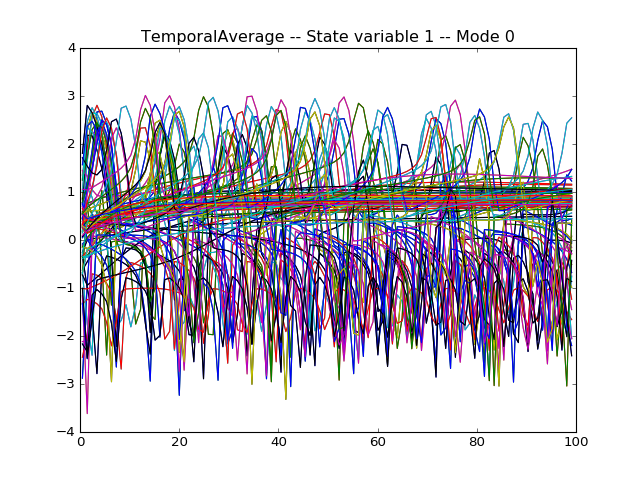

In [10]:
for j, monitor_name in enumerate(monitors):
    figure(j + 1)
    mon_data = numpy.array(result_data[monitor_name])
    for sv in xrange(mon_data.shape[1]):
        for m in xrange(mon_data.shape[3]):
            plot(result_time[monitor_name], mon_data[:, 0, :, 0])
            title(monitor_name + " -- State variable " + str(sv) + " -- Mode " + str(m))